# Solving the Pendulum Motion with Missing Data

## Analysis

The pendulum undergoes simple harmonic motion, and its tangential acceleration, $a(t)=l \frac{d\omega(t)}{dt}=l \frac{d^2\theta(t)}{dt^2}$, is governed by three forces:

- the tangential component of gravity, $F_g(t) = -mg\sin\theta(t)$,
- the frictional (air resistance) force, $f(t)=-\mu v(t)=-\mu l\omega(t)$, and
- the tangential component of the downward pulling force, $F_d(t)$. ($F_d(t)=-F\sin\theta(t)$ when $t\ge t_F$ and zero otherwise.)

Apply Newton's second law, we get

$$
ml \frac{d^2\theta(t)}{dt^2} = -mg\sin\theta(t) - \mu l\frac{d\theta(t)}{dt} - F_d(t).
$$

Given datapoints $(t, \theta(t))$, we want to find paramters $l$, $\mu$, $F$, $t_F$.

## Load data

In [1]:
import os
import random
import torch
import zipfile
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.integrate import solve_ivp

TEST_PATH = Path(os.environ.get("DATA_PATH") or "")  # For grader
TRAIN_PATH = Path("")
if TEST_PATH != TRAIN_PATH:
    TRAIN_PATH = Path("/bohr/train-08bw/v1")

seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
df_train = pd.read_csv(TRAIN_PATH / "pendulum_train.csv")
df_train

,t,theta
0,0.000000,1.050000
1,0.015015,1.049805
2,0.030030,1.049222
3,0.045045,1.048253
4,0.060060,1.046903
...,...,...
729,14.939940,-0.003654
730,14.954955,-0.004669
731,14.969970,-0.005666
732,14.984985,-0.006643


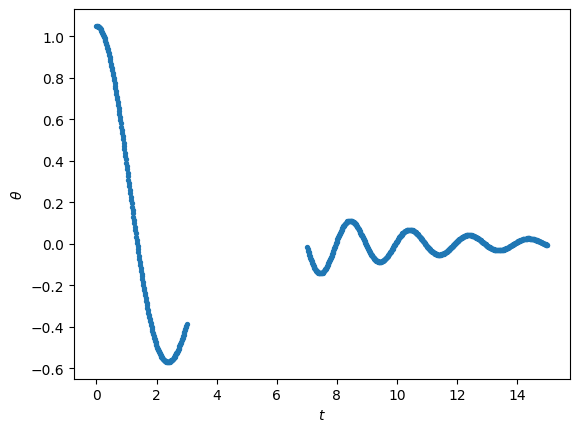

In [3]:
plt.scatter(df_train["t"], df_train["theta"], s=8)
plt.xlabel("$t$")
plt.ylabel(r"$\theta$");

In [4]:
def get_gap(df):
    col = df["t"]
    tmp = col.diff().argmax()
    return col.iloc[tmp - 1], col.iloc[tmp]

In [5]:
train_gap_start, train_gap_end = get_gap(df_train)
train_gap_start, train_gap_end

(3.003003003003003, 7.012012012012012)

In [6]:
def to_tensor(df):
    t = torch.tensor(df["t"].to_numpy())
    theta = torch.tensor(df["theta"].to_numpy())
    dtheta = torch.gradient(theta, spacing=t[1] - t[0])[0]
    d2theta = torch.gradient(dtheta, spacing=t[1] - t[0])[0]
    return torch.vstack([t, theta, dtheta, d2theta]).T

The gradients (`dtheta`, `d2theta`) significantly affect model accuracy. `torch.gradient` uses central differences, giving smoother and more accurate estimates.

I tried `torch.diff` with division by `t` (forward differences). The gradients were noisier.

In [7]:
def preprocess(df):
    gap_start, gap_end = get_gap(df)
    
    first_half = to_tensor(df[df["t"] <= gap_start])
    first_half[0, 2:] = 0
    second_half = to_tensor(df[df["t"] >= gap_end])[1: ]  # first row has no reliable dtheta and d2theta
    
    return torch.cat([first_half, second_half])

In [8]:
train_data = preprocess(df_train)
train_data.shape

torch.Size([733, 4])

In [9]:
# Constants
m = 1
g = 9.8

## Define model and train

Since we lack data near $t_F$, we can fix $t_F$ to any value within the gap when training $l$, $\mu$ and $F$.

In [10]:
class MyModel(nn.Module):
    def __init__(self, gap_t):
        super().__init__()
        self.gap_t = gap_t
        self.raw_l = nn.Parameter(torch.randn(()))
        self.raw_mu = nn.Parameter(torch.randn(()))
        self.raw_F = nn.Parameter(torch.randn(()))

    @property
    def l(self):
        return F.softplus(self.raw_l)  # positive

    @property
    def mu(self):
        return F.softplus(self.raw_mu)  # positive

    @property
    def F(self):
        return F.softplus(self.raw_F)  # positive

    def forward(self, x):
        t, theta, dtheta, d2theta = x.unbind(dim=1)
        
        F_d = self.F * torch.sin(theta)
        mask = (t >= self.gap_t)  # Pulling force acts when t >= gap_t, gap_t not accurate is ok
        F_d *= mask.float()
        
        return m * self.l * d2theta + m * g * torch.sin(theta) + self.mu * self.l * dtheta + F_d

In [11]:
def train(model, optimizer, inputs, num_epochs, logging_interval=20):
    for epoch in range(num_epochs):
        model.train()

        outputs = model(inputs).squeeze(-1)
        loss = F.mse_loss(outputs, torch.zeros_like(outputs))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % logging_interval == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

In [12]:
@torch.no_grad()
def predict(model, inputs):
    outputs = model(inputs).squeeze(-1)
    return outputs.detach().cpu()

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel((train_gap_start + train_gap_end) / 2)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [14]:
train(model.to(device), optimizer, train_data.to(device), 8000, 500)

Epoch [1/8000], Loss: 4.950442129810279
Epoch [501/8000], Loss: 1.4249838911691641
Epoch [1001/8000], Loss: 1.0000725397465624
Epoch [1501/8000], Loss: 0.7183319092438403
Epoch [2001/8000], Loss: 0.5129674180525355
Epoch [2501/8000], Loss: 0.3637680810310431
Epoch [3001/8000], Loss: 0.2588443174734451
Epoch [3501/8000], Loss: 0.1890693876274591
Epoch [4001/8000], Loss: 0.14638083202753888
Epoch [4501/8000], Loss: 0.12321865981084706
Epoch [5001/8000], Loss: 0.11262000560381745
Epoch [5501/8000], Loss: 0.10879699678063263
Epoch [6001/8000], Loss: 0.1078003018617348
Epoch [6501/8000], Loss: 0.10763143667389577
Epoch [7001/8000], Loss: 0.10761509296427754
Epoch [7501/8000], Loss: 0.10761432342480177
Epoch [8000/8000], Loss: 0.10761430903049855


In [15]:
train_l, train_mu, train_F = model.l.item(), model.mu.item(), model.F.item()
train_l, train_mu, train_F

(4.9179253578186035, 0.4993065595626831, 40.134483337402344)

## Find $t_F$ and next $\theta=0$

Given a value of $t_F$, `solve_ivp` can reconstruct the graph of $\theta$ versus $t$.

To determine the true $t_F$, we compare the predicted $\theta$ values from `solve_ivp` with the observed data.
We then extend the graph a few seconds beyond the last recorded time to find the first sign change in $\theta$; this gives us $t_{\text{next zero } \theta}$.

In [16]:
train_t_end = df_train["t"].max()
train_t_end

15.0

In [17]:
train_theta0 = df_train[df_train["t"] == 0]["theta"].item()
train_theta0

1.05

In [18]:
def ivp(t_F, model, theta0, t_eval):
    
    def ode_fn(t, y, l, mu, F, t_F):
        theta, dtheta = y
        
        F_d = (F / (m * l)) * np.sin(theta) if t >= t_F else 0
        
        d2theta = -(g / l) * np.sin(theta) - (mu / m) * dtheta - F_d
        return [dtheta, d2theta]
    
    return solve_ivp(ode_fn, (0, t_eval.max().item()), (theta0, 0),
                     t_eval=t_eval, args=(model.l.item(), model.mu.item(), model.F.item(), t_F)).y[0, :]

In [19]:
def find_t_F(model, data, theta0, gap_start, gap_end, step=0.005):
    
    def loss_fn(t_F, t_eval, theta_truths):
        theta_preds = torch.tensor(ivp(t_F, model, theta0, t_eval))
        return F.mse_loss(theta_preds, theta_truths).item()

    # Loss function has a sharp jump at t=t_F, optimization such as 
    # scipy.optimize.minimize doesn't work well.
    # Here we use grid search instead.
    possible_t_F = np.arange(gap_start, gap_end, step)
    losses = [(loss_fn(t, data[:, 0], data[:, 1]), t) for t in possible_t_F]
    return min(losses)[1]

In [20]:
train_t_F = find_t_F(model, train_data, train_theta0, train_gap_start, train_gap_end)
train_t_F

4.418003003002973

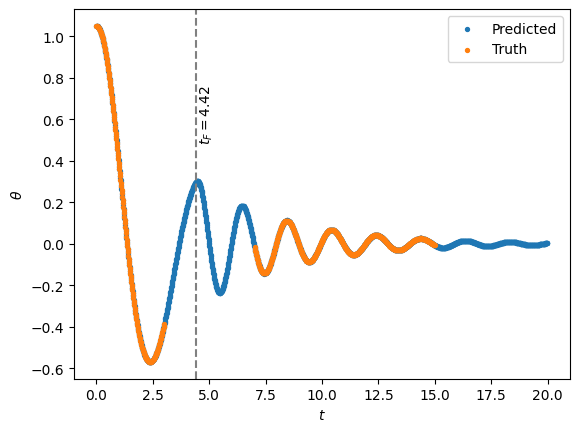

In [21]:
t_samples = np.arange(0, train_t_end + 5, 0.01)

plt.axvline(x=train_t_F, linestyle="--", color="gray")
plt.text(train_t_F + 0.1, 0.5, f"$t_F={train_t_F:.2f}$", color="black", rotation=90)
plt.scatter(t_samples, ivp(train_t_F, model, train_theta0, t_samples), s=8, label="Predicted")
plt.scatter(df_train["t"], df_train["theta"], s=8, label="Truth")
plt.xlabel("$t$")
plt.ylabel(r"$\theta$")
plt.legend();

In [22]:
def find_t_next_zero_theta(model, theta0, t_F, t_record_end, extrapolate=5, granularity=0.005):
    t_samples = np.arange(0, t_record_end + extrapolate, granularity)
    pred_thetas = ivp(t_F, model, theta0, t_samples)

    # Filter out data before the recorder is turned off
    filter_ = np.where(t_samples > t_record_end)[0]
    t_samples, pred_thetas = t_samples[filter_], pred_thetas[filter_]
    
    first_sign_change = np.where(np.diff(np.sign(pred_thetas)) != 0)[0][0]
    return abs(t_samples[first_sign_change] + t_samples[first_sign_change + 1]) / 2

In [23]:
train_t_next_zero_theta = find_t_next_zero_theta(model, train_theta0, train_t_F, train_t_end)
train_t_next_zero_theta

15.8825

## Write answers to file

In [24]:
def write_submission(model, t_F, t_next_zero_theta, filename="submission.csv"):
    df_sub = pd.DataFrame({
        "l": model.l.item(),
        "miu": model.mu.item(),
        "F": model.F.item(),
        "t_nextzerotheta": t_next_zero_theta,
        "t_Fput": t_F
    }, index=[0])
    df_sub.to_csv(filename, index=False)

In [25]:
write_submission(model, train_t_F, train_t_next_zero_theta, "submission_train.csv")

## Repeat for different sets of data (on grader only)

In [26]:
in_filenames = ["pendulum_testA.csv", "pendulum_testB.csv"]
out_filenames = ["submissionA.csv", "submissionB.csv"]
zip_filename = "submission.zip"

In [27]:
for in_filename, out_filename in zip(in_filenames, out_filenames):
    try:
        df_test = pd.read_csv(TEST_PATH / in_filename)
    except FileNotFoundError:
        df_test = None

    if df_test is not None:
        test_gap_start, test_gap_end = get_gap(df_test)
        test_data = preprocess(df_test)
        
        model.gap_t = (test_gap_start + test_gap_end) / 2

        # l, mu, F
        train(model.to(device), optimizer, test_data.to(device), 8000, 500)

        test_t_end = df_test["t"].max()
        test_theta0 = df_test[df_test["t"] == 0]["theta"].item()

        # t_F
        test_t_F = find_t_F(model, test_data, test_theta0, test_gap_start, test_gap_end)
        # t_next_zero_theta
        test_t_next_zero_theta = find_t_next_zero_theta(model, test_theta0, test_t_F, test_t_end)

        write_submission(model, test_t_F, test_t_next_zero_theta, out_filename)

In [28]:
if all([os.path.exists(filename) for filename in out_filenames]):
    with zipfile.ZipFile(zip_filename, "w") as zipf:
        for file in out_filenames:
            zipf.write(file, os.path.basename(file))

## Score

Leaderboard A:

- S1: 0.7985
- S2: 0.9571
- S3: 0.8900
- S4: 0.9753
- S5: 0.7408
- Score: 0.8710